# <div style="border-radius:14px;line-height:1;padding:14px;background-color:#36a294;color:white;text-align:center"> 基于高斯过程回归的股票预测 </div>

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> NoteBook 基本配置 </div>

In [1]:
# 自动加载
%load_ext autoreload
%autoreload 2

# 常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

使用的方法包括:
  1. GP: [出处](https://cs229.stanford.edu/section/cs229-gaussian_processes.pdf)。基本思路是直接预测。来回调整核函数即可。
  2. sparse GP: [出处](https://krasserm.github.io/2020/12/12/gaussian-processes-sparse/)。使用 SITC 进行加速

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> 数据集 </div>
为了便于测试性能，我们与[国外某同学作品](https://www.cs.ubc.ca/~nando/540-2013/projects/p5.pdf?source=post_page---------------------------)进行比对。后文称其作品为 baseline。

选择的股票与 baseline 一致，股票代码分别为: 
  - HPQ(Hewlett-Packard Company)
  - VZ(Yahoo)
  - SBUX(starbucks)。

baseline上使用的股票价格是 Adjusted close price。这项指标是经过经过矫正的价格指标，可以更真实地反映市场趋势，特别适合金融时间序列分析和机器学习模型预测股价走势。它的计算公式为:
$$Adjusted Close = close \times Adjustment Factor$$
$$Adjustment Factor = \frac{1}{Split Ratio} \times \left( 1 - \frac{Dividend}{Price_{before Ex - Divident}} \right)$$

我们在tiingo上获得了与baseline一致的原始数据(相同的时间窗口内相同股票的Adjusted close price)。并进行相同的预处理，获得数据结果如下: 

In [2]:
from utils.data_process import add_time_features 
 
tickers = ["HPQ", "SBUX", "VZ"] 
HPQ = pd.read_csv("data/HPQ.csv", parse_dates=True) 
VZ = pd.read_csv("data/VZ.csv", parse_dates=True) 
SBUX = pd.read_csv("data/SBUX.csv", parse_dates=True) 
DATA_DICT = {"HPQ": HPQ, "VZ": VZ, "SBUX": SBUX} 
 
for t, df in DATA_DICT.items(): 
    # 解码日期, 添加 year, month, day 等特征列 
    df = add_time_features(df) 
 
    # 选取最近 250 天的数据 
    years = df["year"].unique() 
    new_df = [] 
    for y in years: 
        one_df = df[df["year"] == y].sort_values(by="date") 
        one_df = one_df.head(250) 
        new_df.append(one_df) 
    df = pd.concat(new_df) 

    # 获取各年相对数据 (标准化再减去第一天的价格) 
    new_df = []
    for y in years:
        one_df = df[df["year"] == y].copy()
        # 下面的预处理，尽管 baseline 的报告文字部分提到了，但是根据其绘制的图，它们应该并没有用到
        one_df.loc[:, "year_adjClose"] = (one_df["adjClose"] - one_df["adjClose"].mean()) / one_df["adjClose"].std()
        # one_df.loc[:, "year_adjClose"] = one_df["adjClose"]
        one_df.loc[:, "year_adjClose"] = one_df["year_adjClose"] - one_df["year_adjClose"].iloc[0]
        one_df.loc[:, "year_day"] = range(1, 251)
        new_df.append(one_df)
    df = pd.concat(new_df)

    df.loc[:, "std_day"] = (df["day"] - df["day"].mean()) / df["day"].std()   # 把日期也要做标准化! 

    DATA_DICT[t] = df
HPQ = DATA_DICT["HPQ"]
VZ = DATA_DICT["VZ"]
SBUX = DATA_DICT["SBUX"]

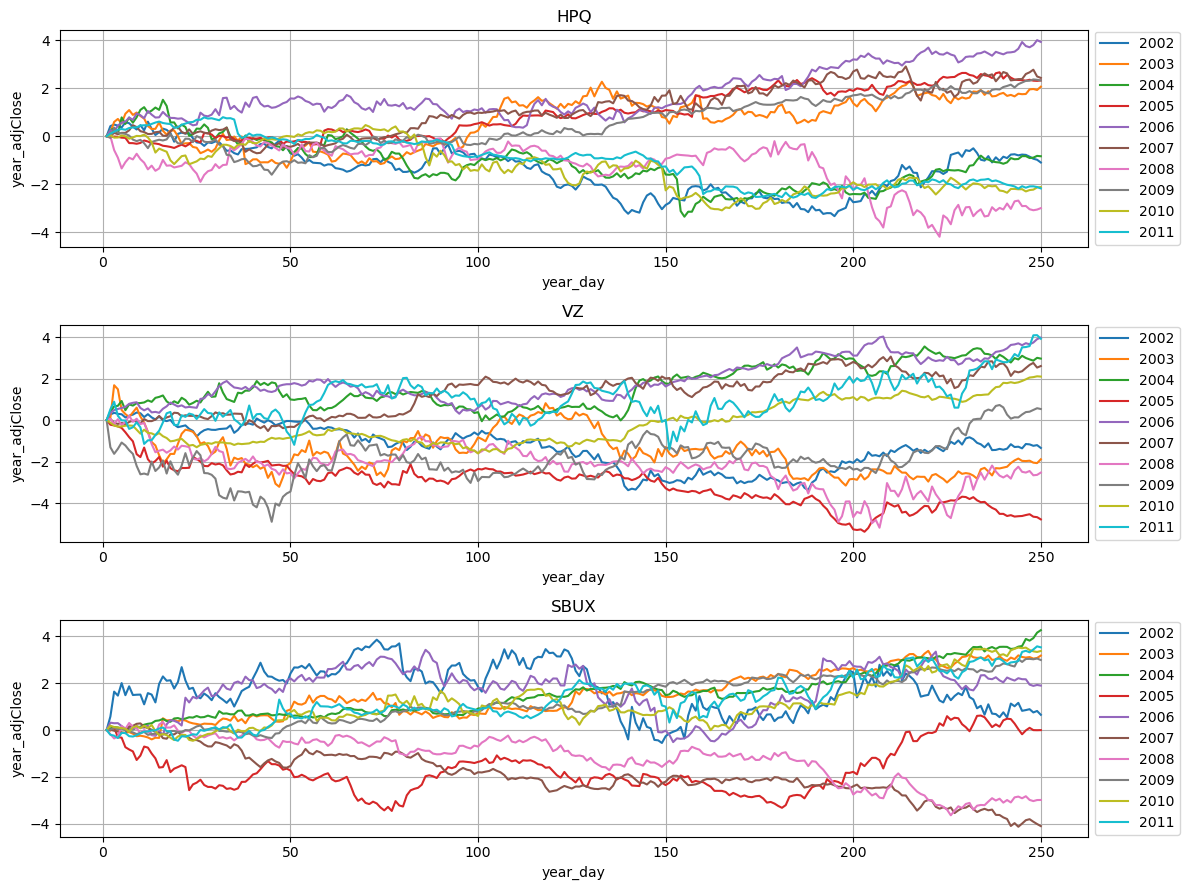

In [3]:
# 绘图, 三个子图, 每个子图一支股票, 子图有10条线, 每条线代表一年的数据
# 十条线互相重合, 横轴范围仅1年(250天)
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
for i, (t, df) in enumerate(DATA_DICT.items()):
    years = df["year"].unique()
    for y in years:
        one_df = df[df["year"] == y]
        ax[i].plot(one_df["year_day"], one_df["year_adjClose"], label=y)
    ax[i].set_title(t)
    ax[i].set_xlabel("year_day")
    ax[i].set_ylabel("year_adjClose")
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].grid(True)

# 避免三个子图重叠
plt.tight_layout()
plt.savefig("figs/stock_yearly.png", dpi=400)

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> Baseline </div>
首先复现baseline.

baseline 上一共进行了两个任务的测评:
  - 对每支股票，2002-2010 以及 2011 年的第 1 季度的数据作为训练集，预测第 2、3、4 季度的价格
  - 对每支股票，2002-2010 以及 2011 年的第 1、2 季度的数据作为训练集，预测第 3、4 季度的价格

### <div style="border-radius:14px;line-height:1;padding:14px;background-color:#68bc6a;color:white;text-align:left"> 任务一 </div>

In [4]:
# 选取训练集和测试集 
from utils.data_process import split_data 
 
HPQ_t1_train, HPQ_t1_test = split_data(HPQ, cutoff=2) # 最后一年第一季度算作训练集  
VZ_t1_train, VZ_t1_test = split_data(VZ, cutoff=2) 
SBUX_t1_train, SBUX_t1_test = split_data(SBUX, cutoff=2) 

HPQ_t1_train = HPQ_t1_train 
VZ_t1_train = VZ_t1_train 
SBUX_t1_train = SBUX_t1_train 

In [16]:
# 使用高斯过程回归模型进行预测
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, DotProduct

# 高斯过程回归模型
# 训练和预测
print("训练 HPQ") 
model = GaussianProcessRegressor( 
    # 使用 rbf, ExpSineSquared, 但是要调好超参数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    alpha=0.1,
)
model.fit(HPQ_t1_train[["std_day"]], HPQ_t1_train["adjClose"]) 
HPQ_t1_test.loc[:, "sklearn_pred"], HPQ_t1_test.loc[:, "sklearn_sigma"] = model.predict( 
            HPQ_t1_test.loc[:, "std_day"].values.reshape(-1, 1),
            return_std=True
        )

print("训练 VZ") 
model = GaussianProcessRegressor( 
    # 使用 rbf, ExpSineSquared, 但是要调好超参数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    alpha=0.1,
)
model.fit(VZ_t1_train[["std_day"]], VZ_t1_train["adjClose"]) 
VZ_t1_test.loc[:, "sklearn_pred"], VZ_t1_test.loc[:, "sklearn_sigma"] = model.predict( 
            VZ_t1_test.loc[:, "std_day"].values.reshape(-1, 1), 
            return_std=True
        ) 

print("训练 SBUX")  
model = GaussianProcessRegressor( 
    # 使用 rbf, ExpSineSquared, 但是要调好超参数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    alpha=0.1,
)
model.fit(SBUX_t1_train[["std_day"]], SBUX_t1_train["adjClose"]) 
SBUX_t1_test.loc[:, "sklearn_pred"], SBUX_t1_test.loc[:, "sklearn_sigma"] = model.predict( 
            SBUX_t1_test.loc[:, "std_day"].values.reshape(-1, 1),
            return_std=True
        )

训练 HPQ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


训练 VZ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


训练 SBUX


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


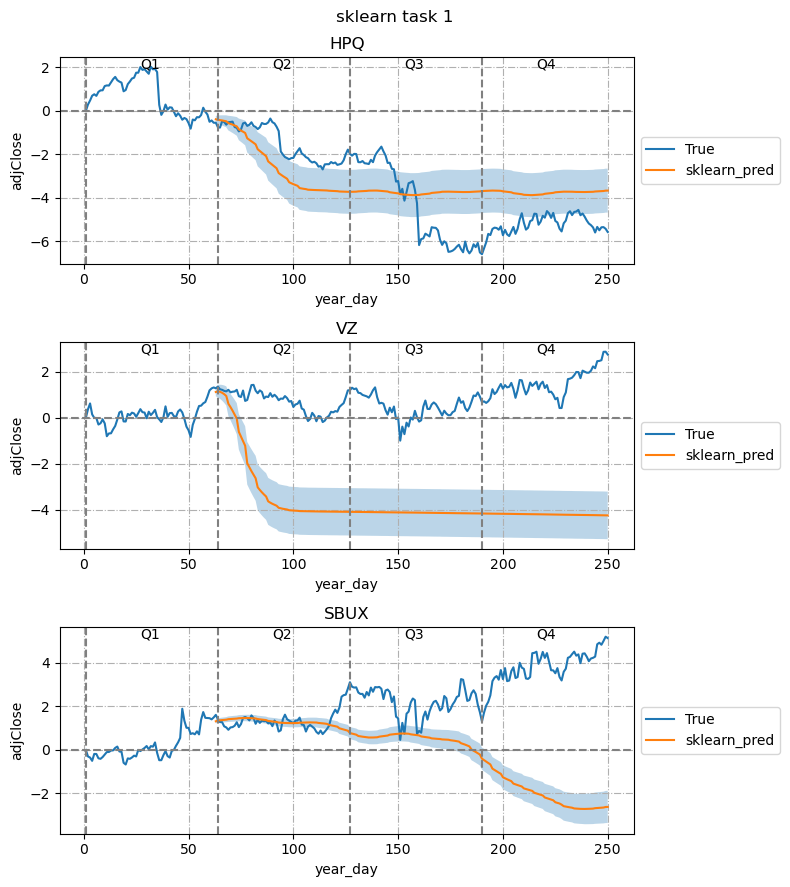

In [18]:
# 绘图展示效果, 仅展示 2011 全年的数据，给出真实值、预测值和误差带
# 注意真实值有250天的，预测值有只有三个季度的
from utils.drow import plot_pred 

plot_pred( 
    [HPQ, VZ, SBUX], 
    [HPQ_t1_test, VZ_t1_test, SBUX_t1_test], 
    pred_cols="sklearn_pred", 
    e_bar = "sklearn_sigma",
    title="sklearn task 1",
)


可以看到，直接使用很多年的结果进行预测的效果非常差。

为了进一步优化，我们实现了使用滑动窗口机制的预测.

### <div style="border-radius:14px;line-height:1;padding:14px;background-color:#68bc6a;color:white;text-align:left"> 任务二 </div>

In [5]:
# 任务 2 对每支股票，2002-2010 以及 2011 年的第 1、2 季度的数据作为训练集，预测第 3、4 季度的价格
# 选取训练集和测试集
HPQ_t2_train, HPQ_t2_test = split_data(HPQ, cutoff=3) # 最后一年第一季度算作训练集  
VZ_t2_train, VZ_t2_test = split_data(VZ, cutoff=3) 
SBUX_t2_train, SBUX_t2_test = split_data(SBUX, cutoff=3) 

HPQ_t2_train = HPQ_t2_train 
VZ_t2_train = VZ_t2_train 
SBUX_t2_train = SBUX_t2_train 

In [21]:
# 使用高斯过程回归模型进行预测
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, RationalQuadratic, WhiteKernel, Matern

# 高斯过程回归模型
# 训练和预测
print("训练 HPQ") 
model = GaussianProcessRegressor( 
    # 使用 Matern 核函数, 更加平稳 , 然后还要再加上一个周期性的核函数, 以及噪声核函数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=2, 
    alpha=0.1,
)
model.fit(HPQ_t2_train[["std_day"]], HPQ_t2_train["adjClose"]) 
HPQ_t2_test.loc[:, "sklearn_pred"], HPQ_t2_test.loc[:, "sklearn_sigma"] = model.predict( 
            HPQ_t2_test.loc[:, "std_day"].values.reshape(-1, 1),
            return_std=True
        )

print("训练 VZ") 
model = GaussianProcessRegressor( 
    # 使用 Matern 核函数, 更加平稳 , 然后还要再加上一个周期性的核函数, 以及噪声核函数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=2, 
    alpha=0.1,
)
model.fit(VZ_t2_train[["std_day"]], VZ_t2_train["adjClose"]) 
VZ_t2_test.loc[:, "sklearn_pred"], VZ_t2_test.loc[:, "sklearn_sigma"] = model.predict( 
            VZ_t2_test.loc[:, "std_day"].values.reshape(-1, 1), 
            return_std=True
        ) 

print("训练 SBUX") 
model = GaussianProcessRegressor( 
    # 使用 Matern 核函数, 更加平稳 , 然后还要再加上一个周期性的核函数, 以及噪声核函数
    kernel=RBF(1.0, (1e-3, 1e3)) + ExpSineSquared(1.0, 0.1, (1e-3, 1e3)) + WhiteKernel(1.0, (1e-5, 1e5)),
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=2, 
    alpha=0.1,
)
model.fit(SBUX_t2_train[["std_day"]], SBUX_t2_train["adjClose"]) 
SBUX_t2_test.loc[:, "sklearn_pred"], SBUX_t2_test.loc[:, "sklearn_sigma"] = model.predict( 
            SBUX_t2_test.loc[:, "std_day"].values.reshape(-1, 1),
            return_std=True
        )

训练 HPQ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
C:\Users\86188\AppData\Local\Temp\ipykernel_19568\3531659614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPQ_t2_test.loc[:, "sklearn_pred"], HPQ_t2_test.loc[:, "sklearn_sigma"] = model.predict(
C:\Users\86188\A

训练 VZ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
C:\Users\86188\AppData\Local\Temp\ipykernel_19568\3531659614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VZ_t2_test.loc[:, "sklearn_pred"], VZ_t2_test.loc[:, "sklearn_sigma"] = model.predict(
C:\Users\86188\App

训练 SBUX


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
C:\Users\86188\AppData\Local\Temp\ipykernel_19568\3531659614.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SBUX_t2_test.loc[:, "sklearn_pred"], SBUX_t2_test.loc[:, "sklearn_sigma"] = model.predict(
C:\Users\86188

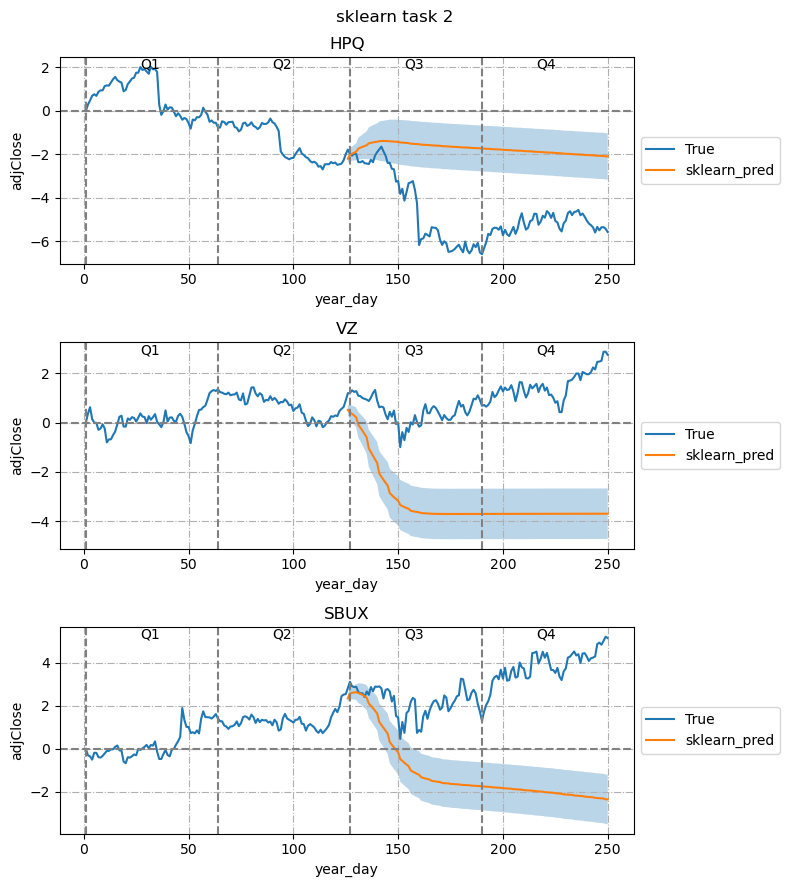

In [22]:
# 绘图展示效果, 仅展示 2011 全年的数据，给出真实值、预测值和误差带
# 注意真实值有250天的，预测值有只有三个季度的
from utils.drow import plot_pred
 
plot_pred( 
    [HPQ, VZ, SBUX], 
    [HPQ_t2_test, VZ_t2_test, SBUX_t2_test],  
    pred_cols="sklearn_pred", 
    e_bar = "sklearn_sigma",
    title="sklearn task 2",
)

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> 我们的模型 </div>

我们实现了两个模型:
  - GP: 标准的高斯过程回归模型
  - Sparse GP: 有加速优化的高斯回归模型

这是给出 Sparse GP 的预测效果

In [45]:
# 使用我们的模型进行任务二的预测
from models.MyGP import SparseGP
from utils.utils import dist_spuare

def rbf(x1,x2,l,s):
    return l*np.exp(-s*dist_spuare(x1,x2))

# 高斯过程回归模型
print("训练 HPQ")
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])
model.fit(HPQ_t2_train[-500:][["std_day"]], 5, HPQ_t2_train[-500:]["adjClose"])
HPQ_t2_test.loc[:, "MySGP_std"], HPQ_t2_test.loc[:, "MySGP_pred"] = model.predict(HPQ_t2_test.loc[:, "std_day"].values.reshape(-1, 1))

print("训练 VZ")   
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])   
model.fit(VZ_t2_train[-500:][["std_day"]], 5, VZ_t2_train[-500:]["adjClose"])    
VZ_t2_test.loc[:, "MySGP_std"], VZ_t2_test.loc[:, "MySGP_pred"] = model.predict(VZ_t2_test.loc[:, "std_day"].values.reshape(-1, 1)) 

print("训练 SBUX")   
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])   
model.fit(SBUX_t2_train[-500:][["std_day"]], 5, SBUX_t2_train[-500:]["adjClose"])    
SBUX_t2_test.loc[:, "MySGP_std"], SBUX_t2_test.loc[:, "MySGP_pred"] = model.predict(SBUX_t2_test.loc[:, "std_day"].values.reshape(-1, 1)) 

训练 HPQ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


训练 VZ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


训练 SBUX


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
# 使用 PyGP 进行预测的 SparseGP
from 




In [10]:
from smt.surrogate_models import KRG
import numpy as np
import pandas as pd

# 训练 Sparse GP 模型并进行预测
def train_smt_gp(train_data, test_data, kernel_name):
    # 初始化 KRG 模型 (smt 的 Gaussian Process)
    smt_model = KRG(
        theta0=[1e-2],  # 初始超参数 theta
        corr=kernel_name,  # 核函数类型，可选 'squar_exp' 或 'abs_exp'
    )
    
    # 提取训练集的输入和输出
    X_train = train_data[["std_day"]].values
    y_train = train_data["adjClose"].values
    
    # 训练 GP 模型
    smt_model.set_training_values(X_train, y_train)
    smt_model.train()
    
    # 使用测试集进行预测
    X_test = test_data["std_day"].values.reshape(-1, 1)
    y_pred = smt_model.predict_values(X_test)
    y_std = smt_model.predict_variances(X_test)     # Variance for uncertainty estimation

    # 存储预测结果
    test_data["smt_pred"] = y_pred.ravel()
    test_data["smt_std"] = np.sqrt(y_std).ravel()    # 标准差为方差的平方根
    return test_data

# 训练 HPQ 的 Sparse GP 模型
print("训练 HPQ")
HPQ_t2_test = train_smt_gp(HPQ_t2_train, HPQ_t2_test, kernel_name='squar_exp')

# 训练 VZ 的 Sparse GP 模型
print("训练 VZ")
VZ_t2_test = train_smt_gp(VZ_t2_train, VZ_t2_test, kernel_name='squar_exp')

# 训练 SBUX 的 Sparse GP 模型
print("训练 SBUX")
SBUX_t2_test = train_smt_gp(SBUX_t2_train, SBUX_t2_test, kernel_name='squar_exp')

训练 HPQ
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 2375
   
___________________________________________________________________________
   
 Training
   
   Training ...
exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1335-th leading minor of the array is not positive definite
[2.32881299e+

C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_pred"] = y_pred.ravel()
C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_std"] = np.sqrt(y_std).ravel()  # 标准差为方差的平方根


exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1335-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171248e+01+0.00000000e+00j
 3.67989239e-01+0.00000000e+00j ... 2.23306761e-14+1.12129247e-16j
 2.23306761e-14-1.12129247e-16j 2.22556260e-14+0.00000000e+00j]
exception :  1335-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171248e+01+0.00000000e+00j
 3.67989239e-01+0.00000000e+00j ... 2.23306761e-14+1.12129247e-

C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_pred"] = y_pred.ravel()
C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_std"] = np.sqrt(y_std).ravel()  # 标准差为方差的平方根


exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1312-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171229e+01+0.00000000e+00j
 3.67989207e-01+0.00000000e+00j ... 2.23839171e-14+1.32408393e-16j
 2.23839171e-14-1.32408393e-16j 2.23446667e-14+0.00000000e+00j]
exception :  1335-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171248e+01+0.00000000e+00j
 3.67989239e-01+0.00000000e+00j ... 2.23306761e-14+1.12129247e-16j
 2.23306761e-14-1.12129247e-16j 2.22556260e-14+0.00000000e+00j]
exception :  1335-th leading minor of the array is not positive definite
[2.32881299e+03+0.00000000e+00j 4.58171248e+01+0.00000000e+00j
 3.67989239e-01+0.00000000e+00j ... 2.23306761e-14+1.12129247e-

C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_pred"] = y_pred.ravel()
C:\Users\86188\AppData\Local\Temp\ipykernel_1824\4208188198.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["smt_std"] = np.sqrt(y_std).ravel()  # 标准差为方差的平方根


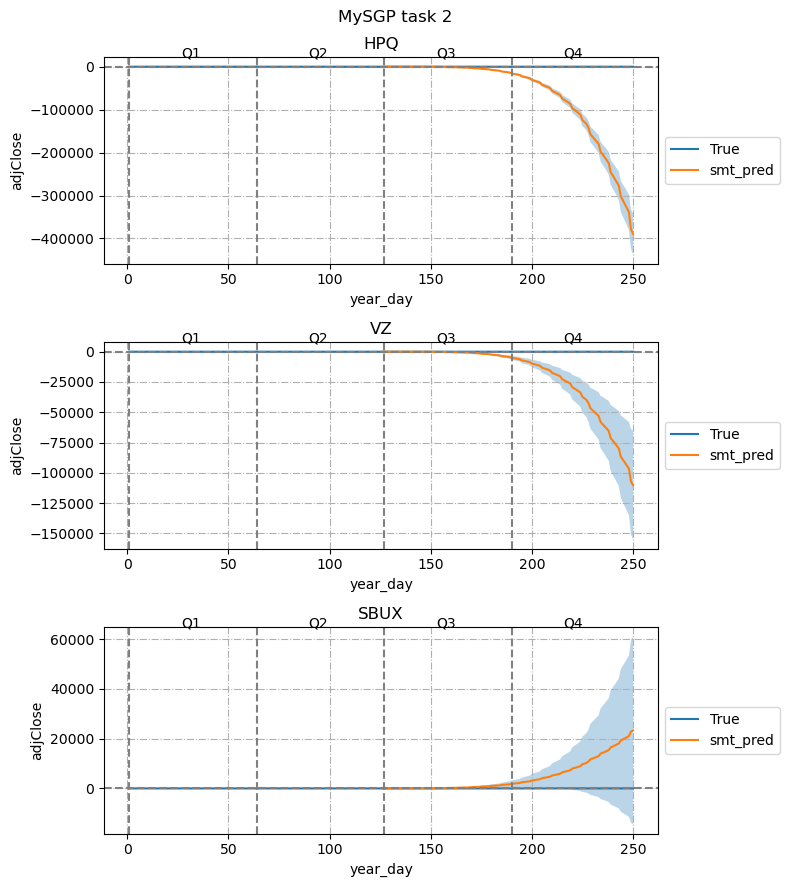

In [11]:
from utils.drow import plot_pred

plot_pred( 
    [HPQ, VZ, SBUX], 
    [HPQ_t2_test, VZ_t2_test, SBUX_t2_test], 
    pred_cols="smt_pred", 
    e_bar = "smt_std",
    title="MySGP task 2",
)

### <div style="border-radius:14px;line-height:1;padding:14px;background-color:#68bc6a;color:white;text-align:left"> 滑动窗口机制 </div>

上面实现了 Sparse GP, 顺利加速了高斯过程回归. 